In [0]:
"""
Notebook de génération des datasets d'entraînement et de test pour l'apprentissage automatique.

Ce notebook transforme les fichiers temporellement recalés en datasets structurés pour 
l'entraînement et l'évaluation de modèles ML. Il implémente une stratégie d'échantillonnage 
aléatoire pour le train et des pourcentages fixes pour le test, garantissant une évaluation 
robuste de la performance temporelle. Il effectue les opérations suivantes :

1. **Analyse exploratoire des données** :
   - Chargement depuis fichiers_temps_recalé/ (séries alignées sur défaut)
   - Comptage total des unités disponibles (machines simulées)
   - Analyse statistique sur échantillon de 10 fichiers
   - Calcul du ratio moyen de défauts par fichier
   - Statistiques min/max du nombre de points temporels
   - Configuration matplotlib/seaborn pour visualisations professionnelles
   - Vérification de la cohérence des colonnes Time et Defaut

2. **Stratégie de split train/test par unité** :
   - Split 80/20 au niveau des unités (pas des points) pour éviter la fuite
   - Mélange aléatoire avec seed=42 pour reproductibilité
   - Séparation stricte : une unité est soit dans train, soit dans test
   - Visualisation pie chart avec explode et shadow effects
   - Sauvegarde du graphique de répartition en haute résolution (300 DPI)
   - Note importante : évite la contamination train/test

3. **Génération du dataset train avec échantillonnage aléatoire** :
   - Pour chaque unité train : tirage aléatoire p ∈ [0%, 100%]
   - Extraction du point au temps t = p% × max(Time)
   - Utilisation de seed incrémental (i+42) pour diversité contrôlée
   - Ajout métadonnées : unit_id, fichier, pourcentage_reel
   - Sauvegarde dataset_train_random.csv avec tous les échantillons
   - Visualisations : distribution uniforme et répartition par classe
   - Statistiques : taux de défaut global, moyenne/écart-type temporel

4. **Génération des datasets test par pourcentage fixe** :
   - Pourcentages définis : [0, 1, 2, ..., 10, 20, 30, ..., 100]
   - Résolution fine (1%) en début de cycle pour détection précoce
   - Résolution standard (10%) après 10% pour efficacité
   - Pour chaque unité test × chaque pourcentage : extraction du point
   - Génération de 21 fichiers : dataset_test_p0.csv à dataset_test_p100.csv
   - Statistiques par pourcentage : nombre d'échantillons, taux de défaut
   - Format cohérent avec colonne "pourcentage" pour traçabilité

5. **Création du dataset pré-défaut pour analyse prédictive** :
   - Lecture depuis fichiers_etiquettes_defaut/ (avant recalage)
   - Identification du premier index où Defaut passe de 0 à 1
   - Extraction du point immédiatement précédent (dernière observation saine)
   - Marquage spécial : pourcentage = -1 pour identification
   - Validation : tous les labels doivent être 0 (pas encore de défaut)
   - Objectif : tester les fausses alarmes juste avant défaut réel
   - Sauvegarde : dataset_test_predefaut.csv

Paramètres et configuration :
- DOSSIER_ENTREE : fichiers_temps_recalé/
- DOSSIER_SORTIE : datasets_par_pourcentage/ (créé automatiquement)
- Split train/test : 80/20 au niveau unité
- Seed global : 42 pour reproductibilité
- Pourcentages test : [0-10] par 1%, [20-100] par 10%

Fichiers générés :
- dataset_train_random.csv : échantillonnage aléatoire [0-100%]
- dataset_test_p{X}.csv : 21 fichiers pour X ∈ {0,1,...,10,20,30,...,100}
- dataset_test_predefaut.csv : points juste avant défaut
- repartition_train_test.png : visualisation du split
- distribution_train_analysis.png : analyse de l'échantillonnage

Stratégie d'évaluation temporelle :
- Train : échantillonnage uniforme pour robustesse
- Test : pourcentages fixes pour courbe de performance
- Pré-défaut : test spécifique des fausses alarmes
- Séparation stricte par unité : pas de contamination

"""

In [0]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [0]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

In [0]:
DOSSIER_ENTREE = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/fichiers_temps_recalé"
DOSSIER_SORTIE = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/datasets_par_pourcentage"
os.makedirs(DOSSIER_SORTIE, exist_ok=True)

1. Analyse exploratoire des données

In [0]:
print(" PHASE 1: ANALYSE EXPLORATOIRE DES DONNÉES")
print("-" * 60)

all_files = sorted([f for f in os.listdir(DOSSIER_ENTREE) if f.endswith(".csv")])
print(f" Nombre total d'unités (machines) disponibles: {len(all_files)}")

defaut_stats = []
for file in all_files[:10]:  # Analyse de la distribution des défauts sur 10 échantillons
    df = pd.read_csv(os.path.join(DOSSIER_ENTREE, file))
    defaut_ratio = df['Defaut'].sum() / len(df) if 'Defaut' in df.columns else 0
    defaut_stats.append({
        'file': file,
        'total_points': len(df),
        'defaut_points': df['Defaut'].sum() if 'Defaut' in df.columns else 0,
        'defaut_ratio': defaut_ratio
    })

df_stats = pd.DataFrame(defaut_stats)
print(f"\n Statistiques sur échantillon de 10 fichiers:")
print(f"   - Ratio moyen de défauts: {df_stats['defaut_ratio'].mean():.2%}")
print(f"   - Min points par fichier: {df_stats['total_points'].min()}")
print(f"   - Max points par fichier: {df_stats['total_points'].max()}")


 PHASE 1: ANALYSE EXPLORATOIRE DES DONNÉES
------------------------------------------------------------
✓ Nombre total d'unités (machines) disponibles: 5552

 Statistiques sur échantillon de 10 fichiers:
   - Ratio moyen de défauts: 100.00%
   - Min points par fichier: 19338
   - Max points par fichier: 19558


2. Stratégie de split train/test



 PHASE 2: STRATÉGIE DE SPLIT TRAIN/TEST
------------------------------------------------------------
✓ Répartition des unités:
   - Train: 4442 unités (80%)
   - Test: 1110 unités (20%)

 Note: Split par unité pour éviter la fuite de données entre train/test


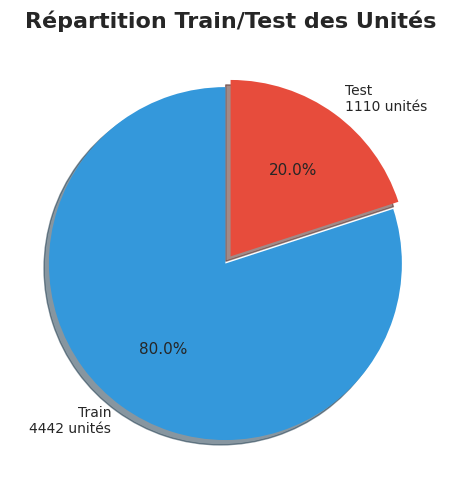

In [0]:
print(f"\n\n PHASE 2: STRATÉGIE DE SPLIT TRAIN/TEST")
print("-" * 60)

random.seed(42)
random.shuffle(all_files) # Split stratifié par unité

n_test = int(0.2 * len(all_files)) # 80/20 split au niveau des unités
test_units = all_files[:n_test]
train_units = all_files[n_test:]

print(f" Répartition des unités:")
print(f"   - Train: {len(train_units)} unités (80%)")
print(f"   - Test: {len(test_units)} unités (20%)")
print(f"\n Note: Split par unité pour éviter la fuite de données entre train/test")

plt.figure(figsize=(8, 5)) # Visualisation de la répartition
sizes = [len(train_units), len(test_units)]
labels = [f'Train\n{len(train_units)} unités', f'Test\n{len(test_units)} unités']
colors = ['#3498db', '#e74c3c']
explode = (0.05, 0)

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', 
        startangle=90, explode=explode, shadow=True)
plt.title('Répartition Train/Test des Unités', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(DOSSIER_SORTIE, "repartition_train_test.png"), dpi=300, bbox_inches='tight')
plt.show()


3. Génération du dataset train avec échantillonnage aléatoire



 PHASE 3: GÉNÉRATION DU DATASET TRAIN
------------------------------------------------------------
 Stratégie: Échantillonnage aléatoire du cycle de vie pour robustesse
✓ Dataset TRAIN généré:
   - 4442 échantillons
   - Taux de défaut: 40.5%
   - Distribution temporelle: μ=49.8%, σ=28.7%


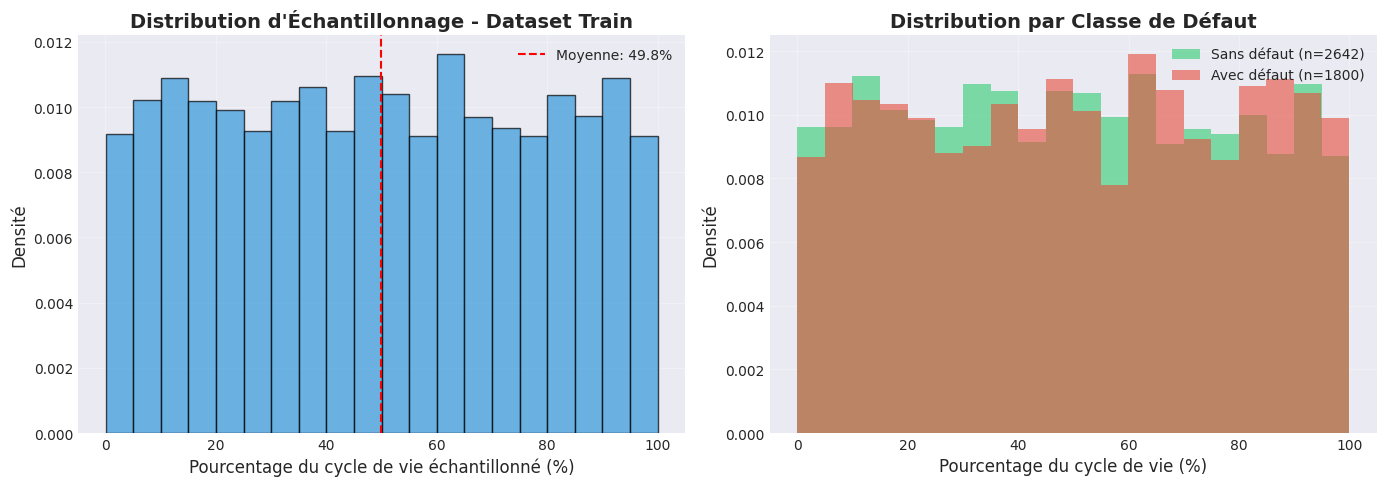

In [0]:
print(f"\n\n PHASE 3: GÉNÉRATION DU DATASET TRAIN")
print("-" * 60)
print(" Stratégie: Échantillonnage aléatoire du cycle de vie pour robustesse")

train_data = []
train_sampling_stats = []

for i, fichier in enumerate(train_units):
    chemin = os.path.join(DOSSIER_ENTREE, fichier)
    try:
        df = pd.read_csv(chemin)
        
        if "Time" not in df.columns or "Defaut" not in df.columns or df.empty:
            continue
        
        random.seed(i + 42)  # Reproductibilité
        p_random = random.uniform(0, 100) # Échantillonnage aléatoire entre 0% et 100% 
        
        t_cible = (p_random / 100) * df["Time"].max() # Extraction du point
        idx = (df["Time"] - t_cible).abs().idxmin()
        
        ligne = df.iloc[idx].copy()
        ligne["fichier"] = fichier
        ligne["unit_id"] = i
        ligne["pourcentage_reel"] = p_random
        
        train_data.append(ligne)
        train_sampling_stats.append(p_random)
        
    except Exception as e:
        print(f"[!] Erreur fichier {fichier}: {e}")
        continue

df_train = pd.DataFrame(train_data)
df_train.to_csv(os.path.join(DOSSIER_SORTIE, "dataset_train_random.csv"), index=False)

print(f" Dataset TRAIN généré:")
print(f"   - {len(df_train)} échantillons")
print(f"   - Taux de défaut: {(df_train['Defaut'].sum() / len(df_train) * 100):.1f}%")
print(f"   - Distribution temporelle: μ={np.mean(train_sampling_stats):.1f}%, σ={np.std(train_sampling_stats):.1f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(train_sampling_stats, bins=20, alpha=0.7, color='#3498db', edgecolor='black', density=True)
ax1.set_xlabel('Pourcentage du cycle de vie échantillonné (%)')
ax1.set_ylabel('Densité')
ax1.set_title('Distribution d\'Échantillonnage - Dataset Train', fontweight='bold')
ax1.axvline(np.mean(train_sampling_stats), color='red', linestyle='--', 
            label=f'Moyenne: {np.mean(train_sampling_stats):.1f}%')
ax1.legend()
ax1.grid(True, alpha=0.3)

defect_pcts = df_train[df_train['Defaut'] == 1]['pourcentage_reel']
no_defect_pcts = df_train[df_train['Defaut'] == 0]['pourcentage_reel']

ax2.hist(no_defect_pcts, bins=20, alpha=0.6, label=f'Sans défaut (n={len(no_defect_pcts)})', 
         color='#2ecc71', density=True)
ax2.hist(defect_pcts, bins=20, alpha=0.6, label=f'Avec défaut (n={len(defect_pcts)})', 
         color='#e74c3c', density=True)
ax2.set_xlabel('Pourcentage du cycle de vie (%)')
ax2.set_ylabel('Densité')
ax2.set_title('Distribution par Classe de Défaut', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(DOSSIER_SORTIE, "distribution_train_analysis.png"), dpi=300, bbox_inches='tight')
plt.show()

4. Génération des datasets test par pourcentage fixe

In [0]:
print(f"\n\n PHASE 4: GÉNÉRATION DES DATASETS TEST TEMPORELS")
print("-" * 60)

pourcentages_test = list(range(0, 11, 1)) + list(range(20, 101, 10)) # Définition des pourcentages de test 
print(f" Points d'évaluation temporels: {pourcentages_test}")
print(f"   → Résolution fine (1%) en début de cycle")
print(f"   → Résolution standard (10%) en milieu/fin de cycle")

datasets_test = {p: [] for p in pourcentages_test}
test_generation_stats = []

for fichier in test_units:
    chemin = os.path.join(DOSSIER_ENTREE, fichier)
    try:
        df = pd.read_csv(chemin)
        
        if "Time" not in df.columns or "Defaut" not in df.columns or df.empty:
            continue
        
        for p in pourcentages_test:
            t_cible = (p / 100) * df["Time"].max()
            idx = (df["Time"] - t_cible).abs().idxmin()
            
            ligne = df.iloc[idx].copy()
            ligne["fichier"] = fichier
            ligne["pourcentage"] = p
            
            datasets_test[p].append(ligne)
            
    except Exception as e:
        continue

test_stats = []
for p, lignes in datasets_test.items():
    df_out = pd.DataFrame(lignes)
    nom_fichier = f"dataset_test_p{p}.csv"
    chemin_sortie = os.path.join(DOSSIER_SORTIE, nom_fichier)
    df_out.to_csv(chemin_sortie, index=False)
    
    defaut_rate = df_out['Defaut'].sum() / len(df_out) if len(df_out) > 0 else 0
    test_stats.append({
        'percentage': p,
        'n_samples': len(df_out),
        'defaut_rate': defaut_rate
    })
    
    print(f"[✓] Test p{p}%: {len(df_out)} échantillons, {defaut_rate:.1%} défauts")



 PHASE 4: GÉNÉRATION DES DATASETS TEST TEMPORELS
------------------------------------------------------------
✓ Points d'évaluation temporels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
   → Résolution fine (1%) en début de cycle
   → Résolution standard (10%) en milieu/fin de cycle
[✓] Test p0%: 1109 échantillons, 41.5% défauts
[✓] Test p1%: 1109 échantillons, 41.5% défauts
[✓] Test p2%: 1109 échantillons, 41.5% défauts
[✓] Test p3%: 1109 échantillons, 41.5% défauts
[✓] Test p4%: 1109 échantillons, 41.5% défauts
[✓] Test p5%: 1109 échantillons, 41.5% défauts
[✓] Test p6%: 1109 échantillons, 41.5% défauts
[✓] Test p7%: 1109 échantillons, 41.5% défauts
[✓] Test p8%: 1109 échantillons, 41.5% défauts
[✓] Test p9%: 1109 échantillons, 41.5% défauts
[✓] Test p10%: 1109 échantillons, 41.5% défauts
[✓] Test p20%: 1109 échantillons, 41.5% défauts
[✓] Test p30%: 1109 échantillons, 41.5% défauts
[✓] Test p40%: 1109 échantillons, 41.5% défauts
[✓] Test p50%: 1109 éch

5. Création du dataset pré-défaut

In [0]:
print(f"\n\n PHASE 5: DATASET PRÉ-DÉFAUT (ANALYSE PRÉDICTIVE)")
print("-" * 60)

DOSSIER_ETIQUETE = "/Volumes/dbe_dbx_internships/justin/predictive_maintenance/fichiers_etiquettes_defaut"
predefaut_samples = []

for idx_file, fichier in enumerate(test_units, 1):
    chemin = os.path.join(DOSSIER_ETIQUETE, fichier)
    if not os.path.exists(chemin):
        continue
    
    df = pd.read_csv(chemin)
    if "Defaut" not in df.columns:
        continue
    
    defect_indices = df.index[df["Defaut"] == 1].tolist() # Trouver la ligne où la valeur de la colonne Defaut passe à 1
    if not defect_indices or defect_indices[0] == 0:
        continue
    
    first_defect_idx = defect_indices[0]
    
    pre_point = df.iloc[first_defect_idx - 1].copy() # Prendre le point juste avant que Defaut passe à 1
    pre_point["fichier"] = fichier
    pre_point["unit_id"] = len(predefaut_samples)
    pre_point["pourcentage"] = -1  
    
    predefaut_samples.append(pre_point)

df_predefaut = pd.DataFrame(predefaut_samples)
predefaut_path = os.path.join(DOSSIER_SORTIE, "dataset_test_predefaut.csv")
df_predefaut.to_csv(predefaut_path, index=False)

print(f" Dataset pré-défaut créé:")
print(f"   - {len(df_predefaut)} points pré-défaut")
print(f"   - Tous labels = 0? {(df_predefaut['Defaut'] == 0).all()}")
print(f"\n Objectif: Tester la capacité du modèle à ne PAS déclencher de fausses alarmes")



 PHASE 5: DATASET PRÉ-DÉFAUT (ANALYSE PRÉDICTIVE)
------------------------------------------------------------
 Dataset pré-défaut créé:
   - 460 points pré-défaut
   - Tous labels = 0? True

 Objectif: Tester la capacité du modèle à ne PAS déclencher de fausses alarmes
